In [1]:
import csv
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import normalized_mutual_info_score as nmi

import pandas

def load_labels(fname):
    data = {}
    with open(fname, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            data[row['subject']] = int(row['label'])
    return data

def load_scores(fname):
    data = {}
    with open(fname, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            data[row['subject']] = float(row['label'])
    return data

hugh = load_labels('mnt/zooniverse/MH2/mh2_golds.csv')
volunteer = load_labels('mnt/zooniverse/MH2/majority_labels.csv')
first = load_labels('mnt/zooniverse/MH2/first_label.csv')
volunteer6 = load_labels('mnt/zooniverse/MH2/majority_labels0.6.csv')
volunteer4 = load_labels('mnt/zooniverse/MH2/majority_labels0.4.csv')
volunteer2 = load_labels('mnt/zooniverse/MH2/majority_labels0.2.csv')
volunteer1 = load_labels('mnt/zooniverse/MH2/majority_labels0.1.csv')
swap = load_scores('mnt/zooniverse/MH2/swap_scores.csv')

subjects = np.array(sorted(hugh.keys()))
# i = np.arange(len(subjects))
print(len(subjects))

hugh = np.array([hugh[s] for s in subjects])
volunteer = np.array([volunteer[s] for s in subjects])
volunteer6 = np.array([volunteer6[s] for s in subjects])
volunteer4 = np.array([volunteer4[s] for s in subjects])
volunteer2 = np.array([volunteer2[s] for s in subjects])
volunteer1 = np.array([volunteer1[s] for s in subjects])
first = np.array([first[s] for s in subjects])
swap = (np.array([swap[s] for s in subjects])>.5).astype(np.int)

print(hugh.shape, volunteer.shape, first.shape)

9897
(9897,) (9897,) (9897,)


## Label Metrics

Calculating the f1 score, precision, and recall of the volunteer labels. Doing this for the volunteer labels and for the first volunteer label per subject.

In [2]:
from muon.dissolving.utils import StandardMetrics
import sklearn.metrics as metrics


standard_metrics = StandardMetrics()
labels = [
    ('vote fractions', volunteer),
    ('swap', swap),
    ('first volunteer', first),
    ('ones', np.ones_like(hugh)),
]

for name, y_pred in labels:
    standard_metrics.add(name, hugh, y_pred)
    
display(standard_metrics.to_df())
# m.dump('mnt/subjects/standard_metrics.csv')

# from muon.dissolving.utils import Metrics
# import pickle
# fname = 'mnt/clustering_models/aws/decv2/rotation/multitask_1-2018-12-09T22:36:29/metrics.pkl'
# with open(fname, 'rb') as f:
#     metrics = pickle.load(f)
# %matplotlib inline
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(8,8))
# metrics.plot(fig, standard_metrics=standard_metrics)

# ax = fig.add_subplot(111)
# ax.set_xticks([.5, 1])
# ax.set_xticklabels(['a', 'b'])
# print(ax.get_xlim())

# plt.show()

Using TensorFlow backend.
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


,name,f1,h,nmi,precision,recall
0,ones,0.519632,-8.565571e-16,-2.500000,0.351015,1.000000
1,vote fractions,0.219929,3.440919e-01,0.364599,0.162411,0.340530
2,first volunteer,0.186345,3.711100e-01,0.383364,0.139618,0.280081
3,swap,0.833156,4.633191e-01,0.473394,0.885076,0.786989


y@x=0.5 [[[0.21992935 0.16241076 0.34052965]]]


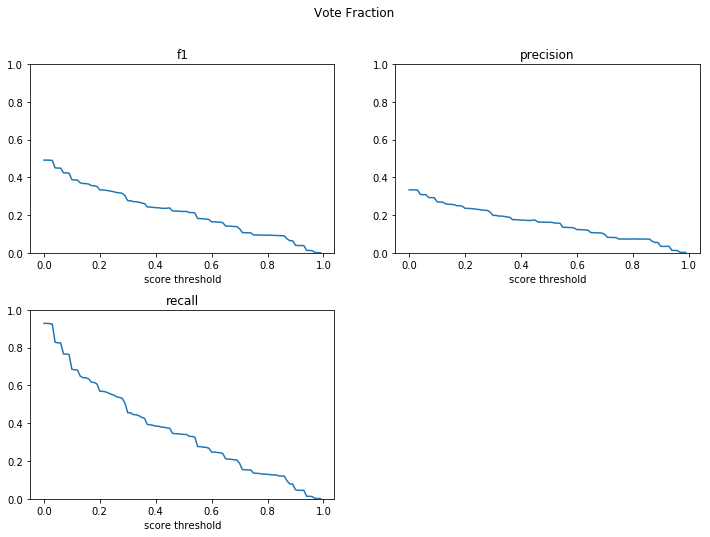

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
        

def plot_score_threshold(golds, scores, title, step=0.01):
    subjects = np.array(sorted(golds.keys()))
    
    golds = np.array([golds[s] for s in subjects])
    scores = np.array([scores[s] for s in subjects])
    
    keys = ['f1', 'precision', 'recall']
    x = np.arange(0, 1, step)
    y = np.zeros((x.shape[0], 3))
    for i, t in enumerate(x):
        labels = (scores>t).astype(np.int)
        metrics_dict = StandardMetrics.calculate_metrics(hugh, labels, '')
        y[i,:] = [metrics_dict[k] for k in keys]

    print('y@x=0.5', y[np.where(x==.5),:])
    fig = plt.figure(figsize=(12,8))
    fig.suptitle(title)
    fig.subplots_adjust(hspace=0.3)
    for i in range(3):
        ax = fig.add_subplot(221+i)
        ax.plot(x, y[:,i])
        ax.set_title(keys[i])
        ax.set_xlabel('score threshold')
        ax.set_ylim((0,1))
    
    return golds, scores, fig


vote_fraction = load_scores('mnt/zooniverse/MH2/fraction.csv')
golds = load_labels('mnt/zooniverse/MH2/mh2_golds.csv')
golds, scores, fig = plot_score_threshold(golds, vote_fraction, 'Vote Fraction')
plt.show()

Figure above shows the f1 score, precision, and recall of the volunteer labels as a function of the threshold used to calculate the label from the vote fractions (a subject is labeled 1 if its score is greater than the threshold). It looks like the raw volunteer labels are just bad. Will generate some swap scores next and see how they compare.

y@x=0.5 [[[0.83315557 0.88507608 0.78698906]]]


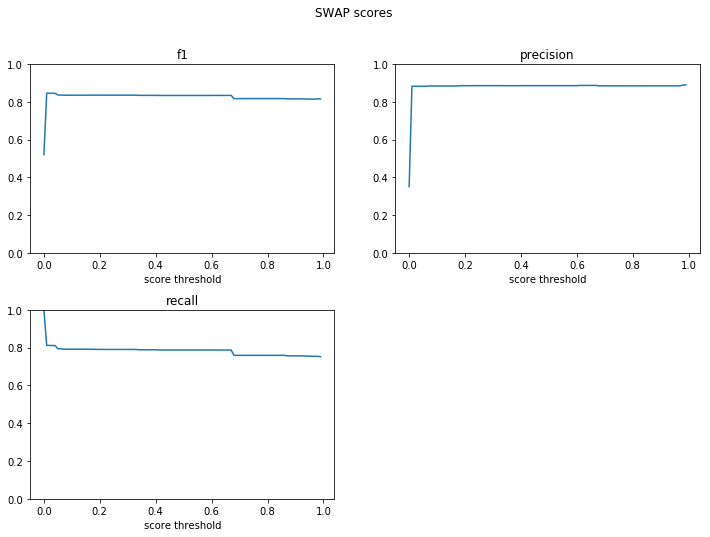

In [4]:
swap_scores =load_scores('mnt/zooniverse/MH2/swap_scores.csv')
golds = load_labels('mnt/zooniverse/MH2/mh2_golds.csv')
golds, scores, fig = plot_score_threshold(golds, swap_scores, 'SWAP scores')
plt.show()

The swap scores are performing much better.

## Data Splits

Reserved all subjects labelled by Hugh, and split them 50%-50% into the validation and test sets. Split up the remaining volunteer labelled subjects that were not labelled by Hugh with 90% in the train set and 10% in the train_dev set.

Data set with rotation

In [5]:
import pickle
def report_splits(fname):
    with open(fname, 'rb') as file:
        splits = pickle.load(file)

    keys = ['train', 'train_dev', 'valid', 'test']
    stats = np.zeros((2, 4))
    stats[0,:] = np.array([splits[k][1].shape[0] for k in keys])
    stats[1,:] = stats[0,:] / np.sum(stats[0,:]) * 100

    df = pandas.DataFrame(stats, columns=keys)
    df.insert(0, '', ['n', 'fraction (%)'])
    
    total_subjects = int(np.sum(stats[0,:]))
    return df, total_subjects

df, N = report_splits('mnt/subjects/split_v2_rotation_xy.pkl')
display(df)
print('Total subjects: {:d}'.format(N))

,,train,train_dev,valid,test
0,n,372541.000000,41393.000000,4948.000000,4948.000000
1,fraction (%),87.898686,9.766416,1.167449,1.167449


Total subjects: 423830


Data set without rotation

In [6]:
df, N = report_splits('mnt/subjects/split_v2_norotation_xy.pkl')
display(df)
print('Total subjects: {:d}'.format(N))

,,train,train_dev,valid,test
0,n,53183.000000,5909.000000,4948.000000,4948.000000
1,fraction (%),77.090219,8.565258,7.172262,7.172262


Total subjects: 68988
